In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime # to handle datetime
import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings('ignore')

# Reading the Data

In [2]:
# reading case data
year = 2011
case_data = pd.read_csv("/kaggle/input/precog/cases/cases/cases_" + str(year) + ".csv")

In [3]:
# reading district and state keys
dist_key = pd.read_csv("/kaggle/input/precog/keys/keys/cases_district_key.csv")
state_key = pd.read_csv("/kaggle/input/precog/keys/keys/cases_state_key.csv")

def retState(state_code, yr):
    ok = state_key['state_name'][((state_key['year']==yr) & (state_key['state_code'] == state_code))].item()
    return str(ok)

In [4]:
# act, section, bailable_ipc(0/1)?, number_sections_ipc, criminal(0/1)?
acts_sections = pd.read_csv("/kaggle/input/precog/acts_sections/acts_sections.csv")

# Assessing the Data
We first examine the data by performing simple checks and verify its validity

In [5]:
# processing the data

# checking for errors
# 1. min/max
print(case_data[['year', 'dist_code', 'state_code','date_of_filing']].agg(['min', 'max']))
print(acts_sections[['bailable_ipc', 'criminal']].agg(['min', 'max']))

# 2. columns with NaN values
print("case_data:", case_data.columns[case_data.isna().any()].tolist())
print("acts_sections:", acts_sections.columns[acts_sections.isna().any()].tolist())

# 3. min/max without NaN values
for i in ['date_of_decision', 'date_first_list', 'date_last_list', 'date_next_list']:
    print(case_data[i][case_data[i].notnull()].agg(['min', 'max']))

for i in ['bailable_ipc']:
    print(acts_sections[i][acts_sections[i].notnull()].agg(['min', 'max']))

# checking if lengths of dates is okay
for i in ['date_of_decision', 'date_first_list', 'date_last_list', 'date_next_list']:
    print(case_data[i][case_data[i].notnull()].str.len().agg(['min', 'max']))

# 4. unique values
for i in ['female_defendant', 'female_adv_def', 'female_adv_pet', 'state_code']:
    if i == 'state_code':
        states = (case_data[i].agg('unique').tolist())
    print(i, ": ", case_data[i].agg('unique').tolist())

for i in ['bailable_ipc', 'criminal']:
    print(i, ":", acts_sections[i].agg('unique').tolist())

     year  dist_code  state_code date_of_filing
min  2011          1           1     2011-01-01
max  2011         76          33     2011-12-31
     criminal
min         0
max         1
case_data: ['purpose_name', 'date_of_decision', 'date_first_list', 'date_last_list', 'date_next_list']
acts_sections: ['act', 'section', 'bailable_ipc', 'number_sections_ipc']
min    0001-02-28
max    5011-07-25
Name: date_of_decision, dtype: object
min    0001-01-28
max    9201-09-14
Name: date_first_list, dtype: object
min    0201-06-14
max    9201-11-08
Name: date_last_list, dtype: object
min    0201-06-15
max    9201-11-09
Name: date_next_list, dtype: object
min                  bailable
max    unclear, need to check
Name: bailable_ipc, dtype: object
min    10
max    10
Name: date_of_decision, dtype: int64
min    10
max    10
Name: date_first_list, dtype: int64
min    10
max    10
Name: date_last_list, dtype: int64
min    10
max    12
Name: date_next_list, dtype: int64
female_defendant :  ['0 male',

As we can see, there are many invalid date values in the date fields.

Now we replace these values with NaN.

In [6]:
# returns NaN if the input date is out of bounds, else returns back the input
def correct_date(d):
    if((not isinstance(d, str)) or (len(d) != 10)):
        return np.NaN
    
    da = datetime(int(d[:4]), int(d[5:7]), int(d[8:]))
    if(datetime(2025, 12, 31) < da or da < datetime(year, 1, 1)):
        return np.NaN
    return d

# Replace irregular data with NaN
for i in ['date_of_decision', 'date_first_list', 'date_last_list', 'date_next_list']:
    case_data[i] = case_data[i].map(correct_date)

# now check again
for i in ['date_of_decision', 'date_first_list', 'date_last_list', 'date_next_list']:
    print(case_data[i][case_data[i].notnull()].agg(['min', 'max']))
    
for i in ['date_of_decision', 'date_first_list', 'date_last_list', 'date_next_list']:
    print(case_data[i][case_data[i].notnull()].str.len().agg(['min', 'max']))

# adding a month field
def retmonth(d):
    return int(d[5:7])
case_data['month'] = case_data.date_of_filing.map(retmonth)

min    2011-01-01
max    2025-10-10
Name: date_of_decision, dtype: object
min    2011-01-01
max    2025-09-25
Name: date_first_list, dtype: object
min    2011-01-01
max    2025-09-25
Name: date_last_list, dtype: object
min    2011-01-01
max    2025-12-25
Name: date_next_list, dtype: object
min    10
max    10
Name: date_of_decision, dtype: int64
min    10
max    10
Name: date_first_list, dtype: int64
min    10
max    10
Name: date_last_list, dtype: int64
min    10
max    10
Name: date_next_list, dtype: int64


# Exploration
## Looking at criminal cases
We join case_[year] data and acts_sections data on the field 'dd_case_id' to gain more information about individual cases.

In [7]:
cases = case_data[['ddl_case_id', 'state_code', 'month']].set_index('ddl_case_id')
acts_sections_join = acts_sections[['ddl_case_id', 'criminal']].set_index('ddl_case_id')
joined = cases.join(acts_sections_join).reset_index()

We plot the number of criminal vs non-criminal cases for each state and look at the percentage of criminal cases.

Some states appear to have extremely high or low percentages and the plots for those is shown as well.

Text(0.5, 0, '')

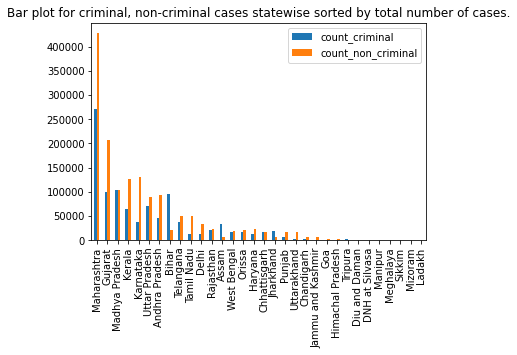

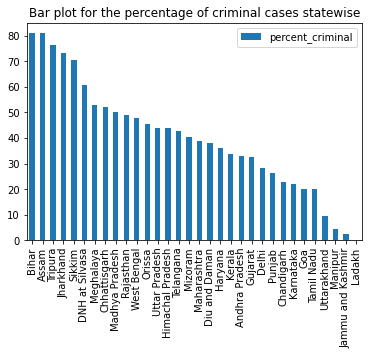

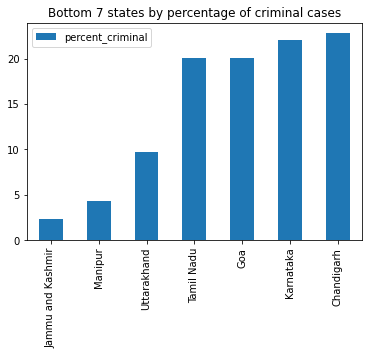

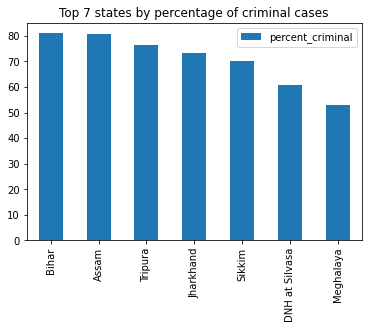

In [8]:
def mapState(s_code):
    return retState(s_code, year)

df = joined[['state_code', 'criminal']].groupby(['state_code', 'criminal']).criminal.agg(['count']).reset_index()

# count of criminal cases state-wise
crim_df = df[['state_code' ,'count']][df['criminal']==0].rename(columns={'state_code':'state', 'count':'count_non_criminal'}).reset_index()
# count of non-criminal cases state-wise
non_crim_df = df[['state_code','count']][df['criminal']==1].rename(columns={'state_code':'state', 'count':'count_criminal'}).reset_index()

crim_df.drop(['index'], inplace=True, axis=1)
non_crim_df.drop(['index'], inplace=True, axis=1)

# joining the two dataframes on state
crim_non_crim_df = crim_df.set_index('state').join(non_crim_df.set_index('state')).reset_index()

# mapping state_code to state_name
crim_non_crim_df['state'] = crim_non_crim_df.state.map(mapState)
crim_non_crim_df = crim_non_crim_df.set_index('state')

# counting total number of cases for each state
crim_non_crim_df['count_total'] = crim_non_crim_df['count_criminal'] + crim_non_crim_df['count_non_criminal']
# plotting count_criminal, count_non_criminal sorted by the total number of cases
crim_non_crim_df.sort_values('count_total', ascending=False)[['count_criminal', 'count_non_criminal']].plot.bar()
plt.title("Bar plot for criminal, non-criminal cases statewise sorted by total number of cases.")
plt.xlabel("")

# calculating the percentage of criminal cases for each state
crim_non_crim_df['percent_criminal'] = (crim_non_crim_df['count_criminal'] / crim_non_crim_df['count_total']) * 100
crim_non_crim_df.drop(['count_criminal', 'count_non_criminal', 'count_total'], inplace=True, axis=1)

crim_non_crim_df.sort_values('percent_criminal', ascending=False).plot.bar()
plt.title("Bar plot for the percentage of criminal cases statewise")
plt.xlabel("")

crim_non_crim_df.sort_values('percent_criminal').head(n=7).plot.bar()
plt.title("Bottom 7 states by percentage of criminal cases")
plt.xlabel("")

crim_non_crim_df.sort_values('percent_criminal', ascending=False).head(n=7).plot.bar()
plt.title("Top 7 states by percentage of criminal cases")
plt.xlabel("")

- Maharashtra has the highest number of overall cases by a significant margin (391414 cases more than the second state).
- In most states, non-criminal cases are more numerous than criminal cases. However there are heavy outliers to this. For example the state of Bihar and Assam have over 80% criminal cases. Influencing factors can be total number of cases, state population, crime rate etc.
- Some states have abnormally low count of criminal cases such as Jammu and Kashmir and Manipur. Influencing factors can be total number of cases, state population, crime rate etc.

## Evolution of number of cases over months and years

### Monthwise analysis
We calculate the average monthly growth rate (AMGR) for each of the states and look for states with high AMGR.

State code does not exist in 2011: 28


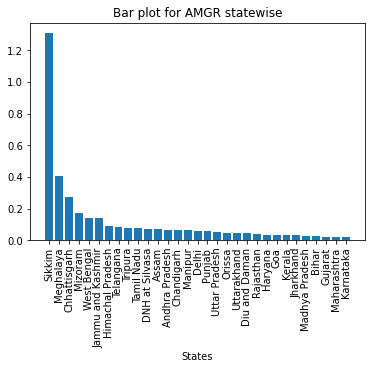

In [9]:
# dictionary to store the average monthly growth rate (AMGR) for each state
amgr_state = {}

# if AMGR is above this, it is too high (decided after looking at AMGRs of all states)
abnorm_amgr_criteria = 0.2

# list to store data for outlier states
abnorm_amgr = []

for i in range(1, 33):
    # check if case data exists for this state for the given year
    if(i not in (states)):
        print("State code does not exist in {}:".format(year), i)
        continue
    
    # create a dataframe containing data of the i^th state grouped by month
    temp_df = case_data[case_data['state_code']==i][['state_code', 'month']].groupby('month').month.agg(['count'])
    for j in range(1, 13):
        if(j not in (temp_df.index.unique())):
            temp_df.append(pd.Series({'count':0}, index=temp_df.columns, name=j))
    
    # calculate AMGR for this state
    temp_df = temp_df.reset_index()
    amgr = 0
    for j in range(2, 13):
        amgr += (temp_df['count'][temp_df['month'] == j].item() / temp_df['count'][temp_df['month'] == (j-1)].item()) - 1
    amgr = amgr/11
    
    # store it into the dictionary
    amgr_state[retState(i, year)] = amgr
    
    # if amgr is abnormal, store the df for plotting later
    if(amgr >= abnorm_amgr_criteria):
        abnorm_amgr.append((i, temp_df))
    

amgr_state = dict(sorted(amgr_state.items(), key=lambda x: x[1], reverse=True))
names = list(amgr_state.keys())
values = list(amgr_state.values())

plt.bar(range(len(amgr_state)), values, tick_label=names)
plt.xticks(rotation=90)
plt.title("Bar plot for AMGR statewise")
plt.xlabel('States')
plt.show()

- Sikkim has an abnormally high average monthly growth rate.
- Meghalaya and Chhattisgarh also display a high AMGR compared to the remaining states.
- Other states show an arbitrary/uniform distribution of cases over months.

This is evident from the month-wise plot of their cases shown below. These states have abnormally high number of cases in some months of the year.

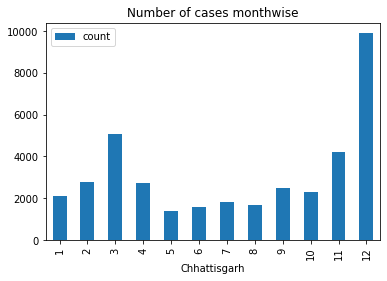

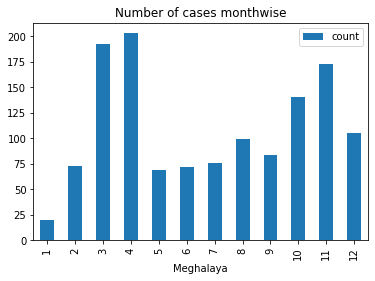

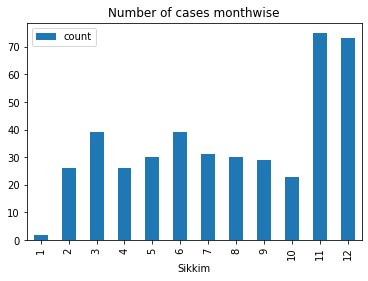

In [10]:
for data in abnorm_amgr:
    data[1].set_index('month').plot.bar()
    plt.xlabel(retState(data[0], year))
    plt.title("Number of cases monthwise")

- Additional Observation: There is also a dip in the number of cases during the middle months of the year for most states.

## Yearwise Analysis
We find out the number of cases for each year for each state. Then we calculate the Average Annual Growth Rate (AAGR) and try to find states with high AAGR.

In [11]:
state_df = []
for i in range(1, 34):
    state_df.append({})

for yr in range(2010, 2019):
    path = "/kaggle/input/precog/cases/cases/cases_" + str(yr) + ".csv"
    df = pd.read_csv(path)
    for i in range(1, 34):
        if(i not in df['state_code'].unique().tolist()):
            print("State code", i, " does not exist for the year", yr, end="\t")
            continue
        x = df['state_code'][df['state_code']==i].size
        state_df[i-1][yr] = x
    print("")

State code 28  does not exist for the year 2010	State code 33  does not exist for the year 2010	
State code 28  does not exist for the year 2011	
State code 28  does not exist for the year 2012	
State code 28  does not exist for the year 2013	
State code 28  does not exist for the year 2014	
State code 28  does not exist for the year 2015	
State code 28  does not exist for the year 2016	
State code 28  does not exist for the year 2017	
State code 28  does not exist for the year 2018	


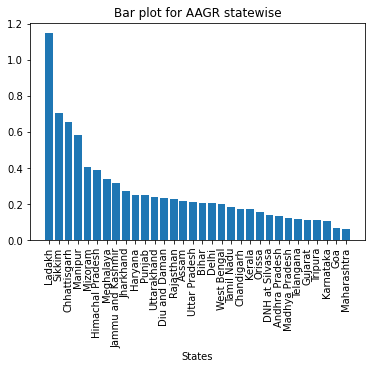

In [12]:
# dict to store AAGR for each state
aagr_state = {}

# criteria for abnormal aagr
aagr_thresh = 0.41

# list to store data for outlier states
abnorm_aagr = []

for i in range(len(state_df)):
    if(i==27): continue
    # calculating aagr
    aagr = 0
    vals = list(state_df[i].values())
    keys = list(state_df[i].keys())
    for j in range(1, len(vals)):
        aagr += vals[j] / vals[j-1] - 1
    aagr = aagr/(len(vals) - 1)
    aagr_state[retState(i+1, keys[-1])] = aagr
    
    # storing the data if its above the threshold
    if(aagr >= aagr_thresh):
        abnorm_aagr.append((i+1, state_df[i]))

aagr_state = dict(sorted(aagr_state.items(), key=lambda x: x[1], reverse=True))
names = list(aagr_state.keys())
values = list(aagr_state.values())

plt.bar(range(len(aagr_state)), values, tick_label=names)
plt.xticks(rotation=90)
plt.title("Bar plot for AAGR statewise")
plt.xlabel('States')
plt.show()

As is evident from the above plot, Ladakh has the highest AAGR by quite a high margin.

The states of Sikkim, Chhattisgarh and Manipur have a much higher AAGR than other states as well.

Other states show more or less an arbitrary/uniform pattern or slight growth of cases over the years.

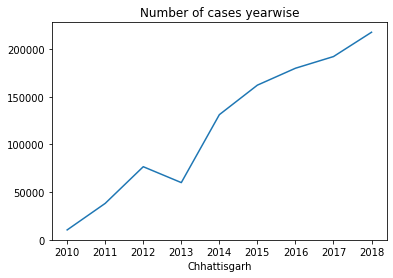

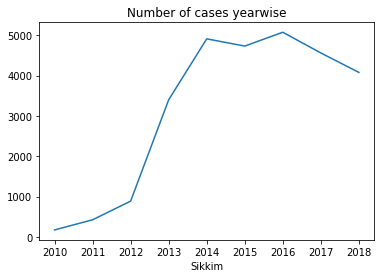

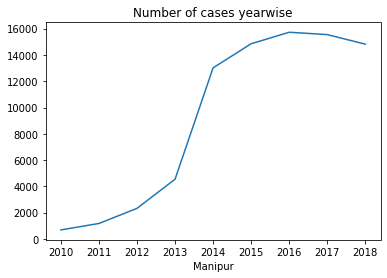

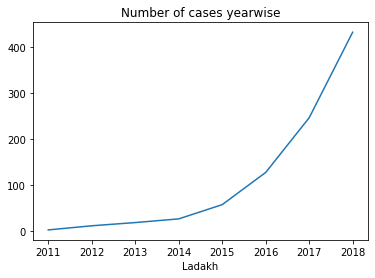

In [13]:
for data in abnorm_aagr:
    names = list(data[1].keys())
    values = list(data[1].values())
    
    plt.plot(names, values)
    plt.xlabel(retState(data[0], names[-1]))
    plt.title("Number of cases yearwise")
    plt.show()

As we can see, the growth of number of cases in these states have been explosive during the last few years, hence the high AAGR.

Also, there can be seen significant growth in number of cases for each state in the form of high AAGR.

## Gender Based Analysis
### Analysis on Judge Data
We study the gender ratio of judges in various states.

In [14]:
# read judges data
judge_data = pd.read_csv("/kaggle/input/precog/judges_clean/judges_clean.csv")

# drop rows where 'female_judge' has value other than '0 nonfemale' or '1 female'

# returns NaN if data is other than '0 nonfemale' or '1 female'
def correct_judge(data):
    if data == '0 nonfemale' or data == '1 female':
        return data
    return np.NaN

judge_data['female_judge'] = judge_data.female_judge.map(correct_judge)
judge_data.dropna(subset=['female_judge'], axis=0, inplace=True)

Text(0.5, 0, '')

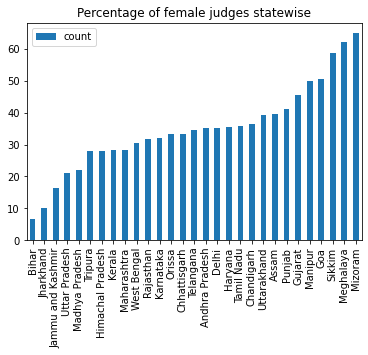

In [15]:
def getState(s):
    return retState(s, 2018)

# number female judges grouped by state
state_female = judge_data[['state_code', 'female_judge']][judge_data['female_judge'] == '1 female'].groupby('state_code').female_judge.agg(['count']).reset_index()

# total number of judges grouped by state
all_states = judge_data[['state_code', 'female_judge']].groupby('state_code').female_judge.agg(['count']).reset_index()

# percentage of female judges for each state
state_female['count'] = (state_female['count'] / all_states['count']) * 100

# Plotting
state_female['state_code'] = state_female.state_code.map(getState)
state_female.sort_values('count').set_index('state_code').plot.bar()
plt.title("Percentage of female judges statewise")
plt.xlabel("")

- States of Mizoram, Sikkim and Meghalaya have a quite high percentage of female judges (more than 50%) as compared with other states.
- States of Bihar and Jharkhand have extremely low percentage of female judges (less than 10%).

### Analysis on Defendant Gender
We find the percentage of female defendants statewise.

Text(0.5, 0, '')

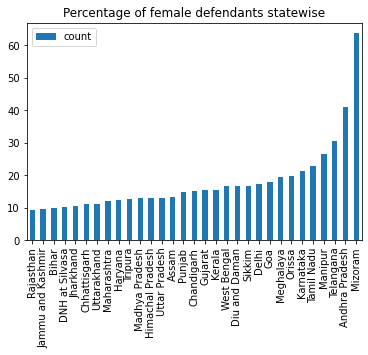

In [16]:
def map_def(row):
    row['count'] = (row['count'] / (all_def['count'][all_def['state_code'] == row.state_code].item())) * 100
    return row

# returns NaN if data is unclear or missing
def correct_defendant(data):
    if data == '0 male' or data == '1 female':
        return data
    return np.NaN

# reading female case data along with case type
female_def = case_data[['female_defendant', 'state_code']][case_data['female_defendant'] == '1 female'].groupby('state_code', as_index=False).female_defendant.agg(['count']).reset_index()

# dropping invalid values from all_data
all_def = case_data[['state_code', 'ddl_case_id', 'female_defendant']]
all_def['female_defendant'] = all_def.female_defendant.map(correct_defendant)
all_def.dropna(subset=['female_defendant'], inplace=True)

all_def = all_def.groupby('state_code', as_index=False).ddl_case_id.agg(['count']).reset_index()

# calculate % female defendants
female_def['count'] = female_def['count'].astype('float64')
female_def = female_def.apply(map_def, axis='columns')

female_def['state_code'] = female_def.state_code.map(getState)

# plot
female_def.set_index('state_code').sort_values('count').plot.bar()
plt.title("Percentage of female defendants statewise")
plt.xlabel("")

## Case Type Analysis
We analyse the type of cases that female and male defendants generally get accused of and display the top 10.

In [17]:
# read type name data
type_name_key = pd.read_csv('/kaggle/input/precog/keys/keys/type_name_key.csv')

def retType(data):
    return type_name_key['type_name_s'][(type_name_key['type_name'] == data) & (type_name_key['year'] == year)].item()

Text(0.5, 1.0, 'Number of cases with male defendants grouped by case type')

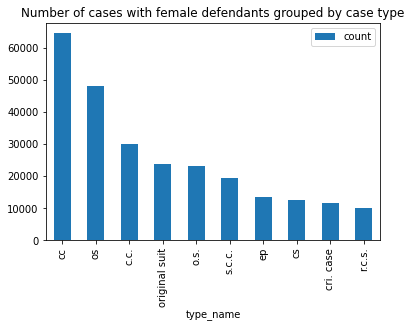

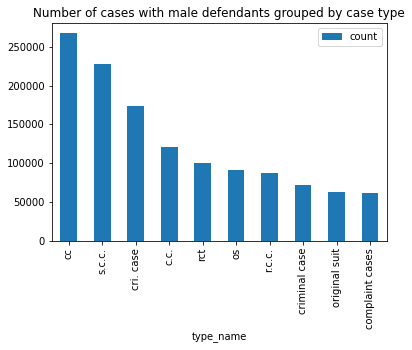

In [18]:
type_fem = case_data[['type_name', 'female_defendant']][case_data['female_defendant'] == '1 female'].groupby('type_name').type_name.agg(['count']).reset_index()
type_fem['type_name'] = type_fem.type_name.map(retType)
type_fem.set_index('type_name').sort_values('count', ascending=False).head(n=10).plot.bar()
plt.title("Number of cases with female defendants grouped by case type")

type_male = case_data[['type_name', 'female_defendant']][case_data['female_defendant'] == '0 male'].groupby('type_name').type_name.agg(['count']).reset_index()
type_male['type_name'] = type_male.type_name.map(retType)
type_male.set_index('type_name').sort_values('count', ascending=False).head(n=10).plot.bar()
plt.title("Number of cases with male defendants grouped by case type")

Now, we analyse the type of cases that female and male advocate defendants prefer and display the top 10.

Text(0.5, 1.0, 'Number of cases with male defendants advocates grouped by case type')

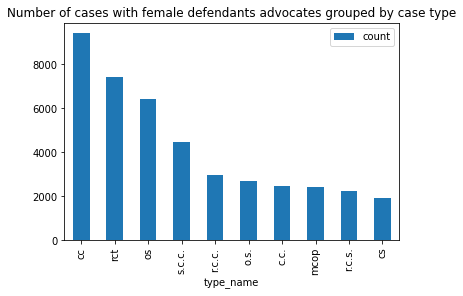

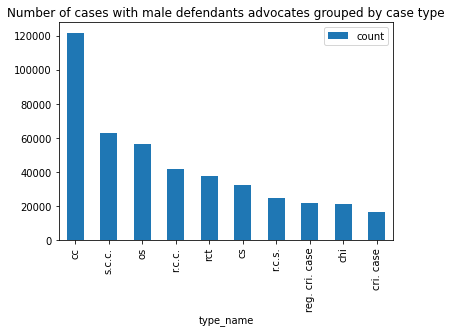

In [19]:
type_fem = case_data[['type_name', 'female_adv_def']][case_data['female_adv_def'] == 1].groupby('type_name').type_name.agg(['count']).reset_index()
type_fem['type_name'] = type_fem.type_name.map(retType)
type_fem.set_index('type_name').sort_values('count', ascending=False).head(n=10).plot.bar()

plt.title("Number of cases with female defendants advocates grouped by case type")

type_male = case_data[['type_name', 'female_adv_def']][case_data['female_adv_def'] == 0].groupby('type_name').type_name.agg(['count']).reset_index()
type_male['type_name'] = type_male.type_name.map(retType)
type_male.set_index('type_name').sort_values('count', ascending=False).head(n=10).plot.bar()
plt.title("Number of cases with male defendants advocates grouped by case type")